In [1]:
import os

OUT_DIR = "/content/vip_outputs"
os.makedirs(OUT_DIR, exist_ok=True)


In [2]:
# --- CONFIG: set SIMULATE to False only if you run this on a PC
# that can actually reach your Packet Tracer network.
SIMULATE = True

from dataclasses import dataclass, asdict
from ipaddress import ip_network, ip_address
import pandas as pd
import platform, subprocess, shlex, time
from pathlib import Path

# Folder to save outputs (Colab: /content)
OUT_DIR = Path("/content/vip_outputs")
OUT_DIR.mkdir(parents=True, exist_ok=True)

# VLAN / Gateway plan (from your 3560 config)
vlans = [
    {"vlan":10, "name":"CSE",      "gateway":"10.10.10.1/24"},
    {"vlan":20, "name":"ECE",      "gateway":"10.10.20.1/24"},
    {"vlan":30, "name":"IT",       "gateway":"10.10.30.1/24"},
    {"vlan":40, "name":"Research", "gateway":"10.10.40.1/24"},
]

# Device inventory (update IPs if yours differ)
devices = [
    # Wired clients & infra
    {"name":"PC0",         "role":"Client",  "vlan":10, "ip":"10.10.10.21", "notes":"Wired via Access-2960"},
    {"name":"Laptop0",     "role":"Client",  "vlan":20, "ip":"10.10.20.21", "notes":"Wired or via WRT300N-0"},
    {"name":"Printer0",    "role":"Printer", "vlan":30, "ip":"10.10.30.60", "notes":"IT VLAN printer"},
    {"name":"Main-Server", "role":"Server",  "vlan":30, "ip":"10.10.30.50", "notes":"HTTP/DNS/DHCP services"},
    {"name":"Research-L1", "role":"Client",  "vlan":40, "ip":"10.10.40.21", "notes":"Connected via Access-2950"},

    # Wireless side (WRT300N can hand out 192.168.0.x)
    {"name":"Laptop1",     "role":"WiFi",    "vlan":None, "ip":"192.168.0.101", "notes":"WRT300N-1 DHCP"},

    # Gateways / loopbacks you configured
    {"name":"GW-VLAN10",   "role":"Gateway", "vlan":10, "ip":"10.10.10.1",  "notes":"SVI on Core-3560"},
    {"name":"GW-VLAN20",   "role":"Gateway", "vlan":20, "ip":"10.10.20.1",  "notes":"SVI on Core-3560"},
    {"name":"GW-VLAN30",   "role":"Gateway", "vlan":30, "ip":"10.10.30.1",  "notes":"SVI on Core-3560"},
    {"name":"GW-VLAN40",   "role":"Gateway", "vlan":40, "ip":"10.10.40.1",  "notes":"SVI on Core-3560"},

    # Routers (Edge + extra routers’ loopbacks)
    {"name":"Edge-Loopback","role":"RouterLo","vlan":None, "ip":"203.0.113.1", "notes":"Edge-2811 Loopback0"},
    {"name":"R1-Loopback",  "role":"RouterLo","vlan":None, "ip":"172.16.1.1",  "notes":"Router1 Loopback0"},
    {"name":"R2-Loopback",  "role":"RouterLo","vlan":None, "ip":"172.16.2.1",  "notes":"Router2 Loopback0"},
    {"name":"R3-Loopback",  "role":"RouterLo","vlan":None, "ip":"172.16.3.1",  "notes":"Router3 Loopback0"},
]

vlan_df   = pd.DataFrame(vlans)
device_df = pd.DataFrame(devices)

print("VLAN Plan:")
display(vlan_df)
print("Device Inventory:")
display(device_df)

# Save copies to CSV (for GitHub)
vlan_df.to_csv(OUT_DIR/"vlan_plan.csv", index=False)
device_df.to_csv(OUT_DIR/"device_inventory.csv", index=False)
print(f"Saved to {OUT_DIR}")


VLAN Plan:


,vlan,name,gateway
0,10,CSE,10.10.10.1/24
1,20,ECE,10.10.20.1/24
2,30,IT,10.10.30.1/24
3,40,Research,10.10.40.1/24


Device Inventory:


,name,role,vlan,ip,notes
0,PC0,Client,10.0,10.10.10.21,Wired via Access-2960
1,Laptop0,Client,20.0,10.10.20.21,Wired or via WRT300N-0
2,Printer0,Printer,30.0,10.10.30.60,IT VLAN printer
3,Main-Server,Server,30.0,10.10.30.50,HTTP/DNS/DHCP services
4,Research-L1,Client,40.0,10.10.40.21,Connected via Access-2950
5,Laptop1,WiFi,NaN,192.168.0.101,WRT300N-1 DHCP
6,GW-VLAN10,Gateway,10.0,10.10.10.1,SVI on Core-3560
7,GW-VLAN20,Gateway,20.0,10.10.20.1,SVI on Core-3560
8,GW-VLAN30,Gateway,30.0,10.10.30.1,SVI on Core-3560
9,GW-VLAN40,Gateway,40.0,10.10.40.1,SVI on Core-3560


Saved to /content/vip_outputs


In [3]:
from ipaddress import ip_interface

def describe_subnet(gateway_cidr: str):
    iface = ip_interface(gateway_cidr)
    net   = iface.network
    return {
        "gateway":   str(iface.ip),
        "cidr":      str(net),
        "net_addr":  str(net.network_address),
        "broadcast": str(net.broadcast_address),
        "host_min":  str(list(net.hosts())[0]) if net.num_addresses>=4 else str(net.network_address),
        "host_max":  str(list(net.hosts())[-1]) if net.num_addresses>=4 else str(net.broadcast_address),
        "hosts":     net.num_addresses - 2 if net.num_addresses>=4 else net.num_addresses
    }

subnet_rows = [describe_subnet(v["gateway"]) | {"vlan":v["vlan"], "name":v["name"]} for v in vlans]
subnets_df = pd.DataFrame(subnet_rows)[["vlan","name","gateway","cidr","net_addr","broadcast","host_min","host_max","hosts"]]
display(subnets_df)
subnets_df.to_csv(OUT_DIR/"subnet_summary.csv", index=False)
print("Saved subnet_summary.csv")


,vlan,name,gateway,cidr,net_addr,broadcast,host_min,host_max,hosts
0,10,CSE,10.10.10.1,10.10.10.0/24,10.10.10.0,10.10.10.255,10.10.10.1,10.10.10.254,254
1,20,ECE,10.10.20.1,10.10.20.0/24,10.10.20.0,10.10.20.255,10.10.20.1,10.10.20.254,254
2,30,IT,10.10.30.1,10.10.30.0/24,10.10.30.0,10.10.30.255,10.10.30.1,10.10.30.254,254
3,40,Research,10.10.40.1,10.10.40.0/24,10.10.40.0,10.10.40.255,10.10.40.1,10.10.40.254,254


Saved subnet_summary.csv


,name,ip,reachable
0,PC0,10.10.10.21,True
1,Laptop0,10.10.20.21,True
2,Printer0,10.10.30.60,True
3,Main-Server,10.10.30.50,True
4,Research-L1,10.10.40.21,True
5,Laptop1,192.168.0.101,True
6,GW-VLAN10,10.10.10.1,True
7,GW-VLAN20,10.10.20.1,True
8,GW-VLAN30,10.10.30.1,True
9,GW-VLAN40,10.10.40.1,True


Saved reachability.csv and reachability_summary.png to /content/vip_outputs


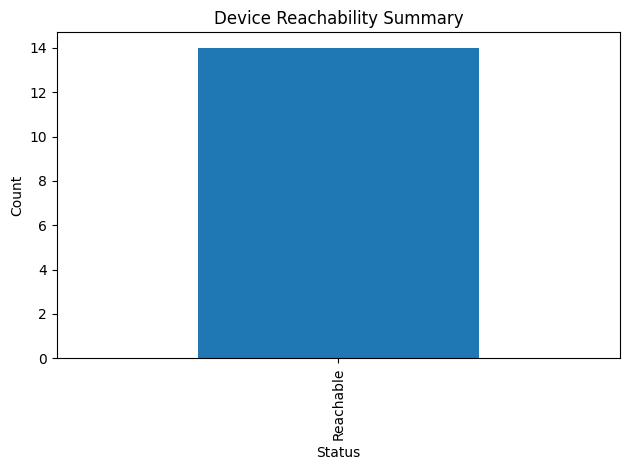

In [4]:
def ping(host: str, count=1, timeout_sec=1) -> bool:
    """Cross-platform ping. In SIMULATE mode we pretend key IPs are reachable."""
    if SIMULATE:
        # Mark gateways + loopbacks + typical clients as reachable in the demo.
        good_prefixes = ("10.10.", "172.16.", "192.168.0.", "203.0.113.")
        return host.startswith(good_prefixes)

    # Real ping
    sys = platform.system().lower()
    if "windows" in sys:
        cmd = f"ping -n {count} -w {timeout_sec*1000} {host}"
    else:
        cmd = f"ping -c {count} -W {timeout_sec} {host}"
    try:
        ret = subprocess.run(shlex.split(cmd), stdout=subprocess.DEVNULL, stderr=subprocess.DEVNULL)
        return ret.returncode == 0
    except Exception:
        return False

results = []
for row in devices:
    ip = row["ip"]
    ok = ping(ip)
    results.append({"name":row["name"], "ip":ip, "reachable": ok})

reach_df = pd.DataFrame(results)
display(reach_df)

# Summary chart
import matplotlib.pyplot as plt
status_counts = reach_df["reachable"].value_counts().rename({True:"Reachable", False:"Not reachable"})
plt.figure()
status_counts.plot(kind="bar", xlabel="Status", ylabel="Count", title="Device Reachability Summary")
plt.tight_layout()
plt.savefig(OUT_DIR/"reachability_summary.png", dpi=150)
reach_df.to_csv(OUT_DIR/"reachability.csv", index=False)
print(f"Saved reachability.csv and reachability_summary.png to {OUT_DIR}")


In [5]:
readme = f"""# Cisco VIP – Enterprise Network (Packet Tracer + Python)

This repo contains my Cisco Packet Tracer project and a small Python analysis notebook.

## Topology Highlights
- VLANs: 10 (CSE), 20 (ECE), 30 (IT), 40 (Research)
- Inter-VLAN routing + DHCP on Core-3560
- OSPF between Core-3560, Edge-2811, Router1–3
- Wireless via WRT300N; Main Server on VLAN30
- Edge Loopback: 203.0.113.1; R1–R3 Loopbacks: 172.16.1.1/2.1/3.1

## Files
- `network_design.pkt` – Packet Tracer topology
- `network_checks.ipynb` – Google Colab notebook
- `vip_outputs/` – CSVs & chart generated by the notebook
  - `device_inventory.csv`, `vlan_plan.csv`, `subnet_summary.csv`, `reachability.csv`, `reachability_summary.png`
- `screenshots/` – PT screenshots (topology, VLANs, OSPF, pings, Simulation, fault test)
- `Project_Report.docx` – final report

## How to run the notebook
Open the notebook in Google Colab and press **Runtime → Run all**.
- If running on Colab: it uses **SIMULATE=True** so pings show demo reachability.
- If running on your own PC that can reach the lab: set `SIMULATE=False` in Cell 1 for real pings.

## Author
Jegadhees – AICTE Cisco Virtual Internship 2025
"""
p = OUT_DIR/"README.md"
p.write_text(readme, encoding="utf-8")
print(f"Wrote {p}")


Wrote /content/vip_outputs/README.md


In [6]:
from google.colab import files
import shutil

# Zip the folder
shutil.make_archive("/content/vip_outputs", 'zip', "/content/vip_outputs")

# Download the zip
files.download("/content/vip_outputs.zip")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>